# Bank Churn Binary Classification

This notebook is created by **Ian Feekes** as part of the kaggle competition playground series season 4, episode 1

The goal of this dataset competition is to predict whether the customer exits their account (i.e. it "Churns").

The evaluation metric is the area under the ROC curve. The ROC curve is an acronym for the "Receiver Operating Characteristic" which is used for evaluating the performance of binary classification models. It is the **true positive rate** against the **false positive rate**

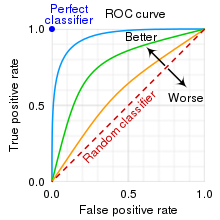

### Other Notebook Observations

Feature engineering columns:

Categorical:
    * **IsSenior** column which is true if one is above the age of 60. It's hard to imagine this being particularly valuable as it should be fairly imbalanced.
    * **IsActive_by_CreditCard** is whether someone is both active and has a credit card
    * **Products Per Tenure** is tenure over the number of products
    * **Age Category** is the ages binned by 20
    * **Customer_Sur_Geo_Gend** is the customer ID + surname + geography + gender

Numerical: Just the default (Age, creditScore, balance, estimated salary, products per tenure)

#### Scale position weight hyperparameter estimate

In [725]:
# from collections import Counter

# counter = Counter(y)
# pos_estimate = counter[0] / counter[1]
# print('Estimate: %.3f' % pos_estimate)

From there you can do a training split to stratify based on the counter e.g. 

```X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)```

Then when you create an XGB Classifier, you add the ```pos_estimate``` as a parameter for the ```scale_pos_weight``` e.g.

```clf = XGBClassifier(scale_pos_weight=pos_estimate, n_estimators = n, enable_categorical=True)```

## Initial Configuration

### Imports

In [726]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from collections import Counter

### Global Variables

In [727]:
target = 'Exited'

### Helper Functions

In [728]:
"""Helper function to show a simple pie chart of a categorical variable for distribution analysis"""
def do_pie(df, col, title=""):
    if col not in df.columns:
        print("Error, column specified is not in the dataframe's columns")
        return
    val_counts = df[col].value_counts()
    plt.pie(val_counts, labels=val_counts.keys(), autopct='%1.1f%%')
    if title == "":
        title = "Distribution of " + col
    plt.title(title)
    plt.show()

"""Helper function to plot side-by-side pie charts for the different survival rates for differing values in a column
  NOTE: the otherCol needs to be a boolean column with value counts else this function will likely break"""
def plot_target_representation(df, col, otherCol=target):
    grouped = df.groupby([col, otherCol]).size().unstack().fillna(0)
    value_counts = df[col].value_counts()
    target_labels = df[otherCol].value_counts().keys().sort_values()
    fig, axes = plt.subplots(1, len(value_counts.keys()), figsize=(16,6))
    for idx, key in enumerate(value_counts.keys()):
        axes[idx].pie(grouped.loc[key], labels=target_labels, autopct='%1.1f%%', startangle=90)
        axes[idx].set_title(col + " " + str(key))
    plt.tight_layout()
    plt.show()

### Load the Dataframe ⬇️

In [729]:
df = pd.read_csv('./train.csv')
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## EDA

The dataframe has 14 columns.
* It looks like the ```id``` is simply the index and will be of no value in analytics.
* ```CustomerId``` may have more meaning in analytics.
* ```Surname``` is a string with plenty of names. In real life applications, this would be considered sensitive data.
* ```CreditScore``` is an integer representing the customer's credit scores. It may be useful to find out the actual bracketing system that most banks use for credit scores.
* ```Geography``` is a string that looks like it has the country of the customer in it. This would also be considered sensitive data in real applications. This variable will likely be valuable and need some encoding.
* ```Gender``` is just **Male** or **Female** as usual.
* ```Age``` is a float interestingly enough.
* ```Tenure``` is an integer
* ```Balance``` is a float
* ```NumOfProducts``` is a float. It may be more of a categorical variable with some outlier testing required.
* ```Has CrCard``` is likely a boolean denoting whether a user has a credit card.
* ```IsActiveMember``` is likely a boolean denoting whether they have been 'active' on the account.
* ```EstimatedSalary``` is a float for their estimated salary
* ```Exited``` is the target variable for bank churn.

In [730]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


There are 165,034 entries in the initial training dataframe.

In [731]:
df.shape

(165034, 14)

In [732]:
df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


There are no missing values on first impression. Granted, it is still possible there are 'valued' missing values (e.g. categorical variables with 'other' or numerical variables that don't make sense)

In [733]:
df.isnull().sum().sum()

0

Indeed the id is just an index and is likely pretty meaningless

In [734]:
df['id'].value_counts().sum() == df.shape[0]

True

There are more men than women account holders

In [735]:
df['Gender'].value_counts()

Gender
Male      93150
Female    71884
Name: count, dtype: int64

In [736]:
df['Age'].value_counts()

Age
37.00    9255
38.00    9246
35.00    9118
34.00    8625
36.00    8556
         ... 
84.00       4
83.00       3
85.00       3
36.44       1
32.34       1
Name: count, Length: 71, dtype: int64

#### 🎯 Target Variable

There is what would be considered by Google to be a **Mild Imbalance** of 21.2% for the target variable.

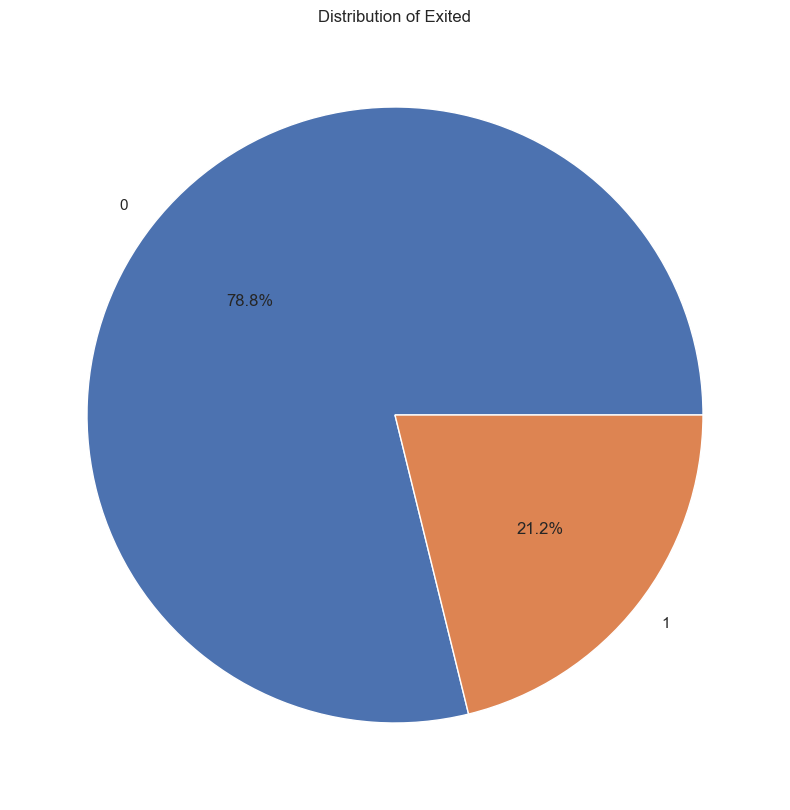

In [737]:
do_pie(df, target)

There are only ```0``` and ```1``` values for whether a customer exited. This variable is already pre-encoded and won't need any cleaning.

In [738]:
df[target].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

#### 🆔 Customer ID

Looking at the value counts, we can see there are **23221** unique values for the customer id. This may be an issue since this might mean there are some duplicates in the data. A few individual rows will need to be examined to determine whether they are pure duplicates or if there are differences - but we note there is no timestamp, so it isn't useful yet to treat the data as time-series.

In [739]:
df['CustomerId'].value_counts()

CustomerId
15682355    121
15570194     99
15585835     98
15595588     91
15648067     90
           ... 
15635203      1
15806982      1
15691104      1
15624936      1
15815050      1
Name: count, Length: 23221, dtype: int64

It doesn't look like there are any pure duplicates in the dataframe.

In [740]:
df.duplicated().sum()

0

Looking at the ```CustomerId``` of a specific value (e.g. **15682355**) we see the entries are completely different. There are multiple values of the ID at a given number with the same surname **Hsueh** with completely different characteristics (gender, age, credit score etc.).

It is possible that we don't fully understand what the CustomerId acutally means.

In [741]:
df[df['CustomerId'] == 15682355]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
273,273,15682355,Hsueh,727,Germany,Male,35.0,9,140966.55,1,1.0,1.0,179227.21,0
2565,2565,15682355,Tien,744,France,Male,37.0,6,0.00,2,1.0,1.0,137944.16,0
5063,5063,15682355,Niu,790,Spain,Male,44.0,1,128100.75,1,1.0,0.0,164517.96,1
11942,11942,15682355,Hsueh,616,France,Female,43.0,9,95167.82,2,0.0,1.0,132741.56,0
13009,13009,15682355,Manna,652,Spain,Female,33.0,7,0.00,2,1.0,1.0,112333.22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159573,159573,15682355,Onwuatuegwu,679,France,Female,39.0,6,0.00,2,1.0,0.0,123977.86,0
159690,159690,15682355,Pinto,629,Germany,Female,34.0,2,140510.34,2,1.0,0.0,143681.75,0
159923,159923,15682355,O'Donnell,710,France,Female,35.0,7,0.00,2,1.0,1.0,147055.87,0
160819,160819,15682355,L?,773,Spain,Male,38.0,6,138597.54,1,1.0,0.0,52314.71,0


#### Surname

There are 2797 unique surnames. They may not be individually useful but perhaps can be used to help infer things.

In [742]:
df['Surname'].value_counts()

Surname
Hsia         2456
T'ien        2282
Hs?          1611
Kao          1577
Maclean      1577
             ... 
Samaniego       1
Lawley          1
Bonwick         1
Tennant         1
Elkins          1
Name: count, Length: 2797, dtype: int64

#### 💳 CreditScore

From the boxplot of credit score values, we are able to see that there is a mean in the mid-high 600's. The max values are at 850, and the minimal values are around 350, with most people exibiting a wide range between 450 and 850. There is a slight left skew, but very-slight.

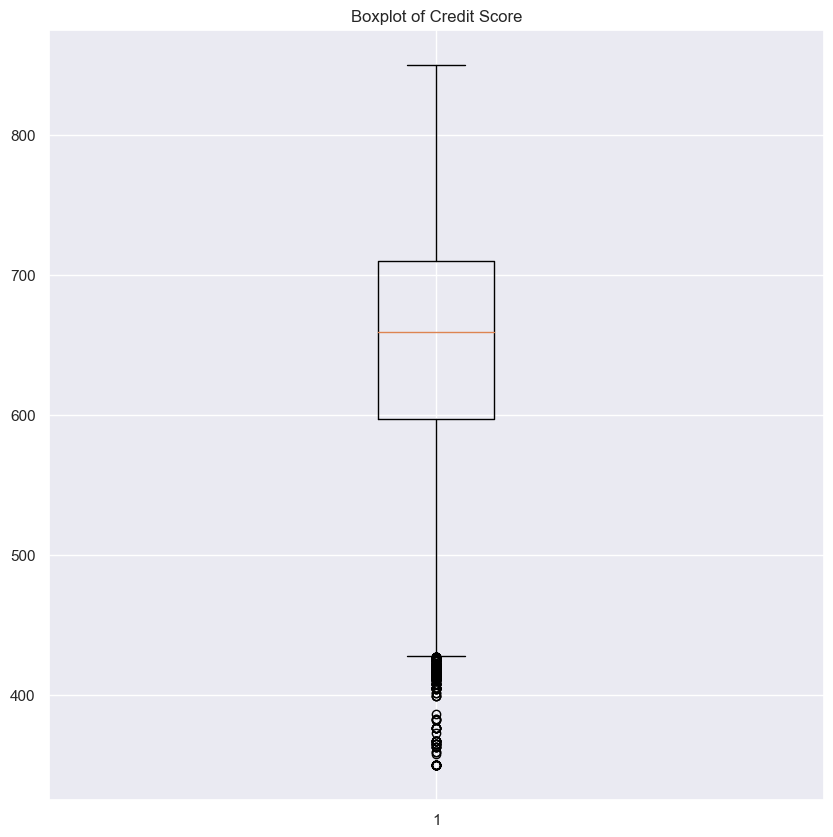

In [743]:
plt.boxplot(df['CreditScore'])
plt.title("Boxplot of Credit Score")
plt.show()

There are some outliers for the credit score and there is definetely a bit of a left skew (but not too bad)

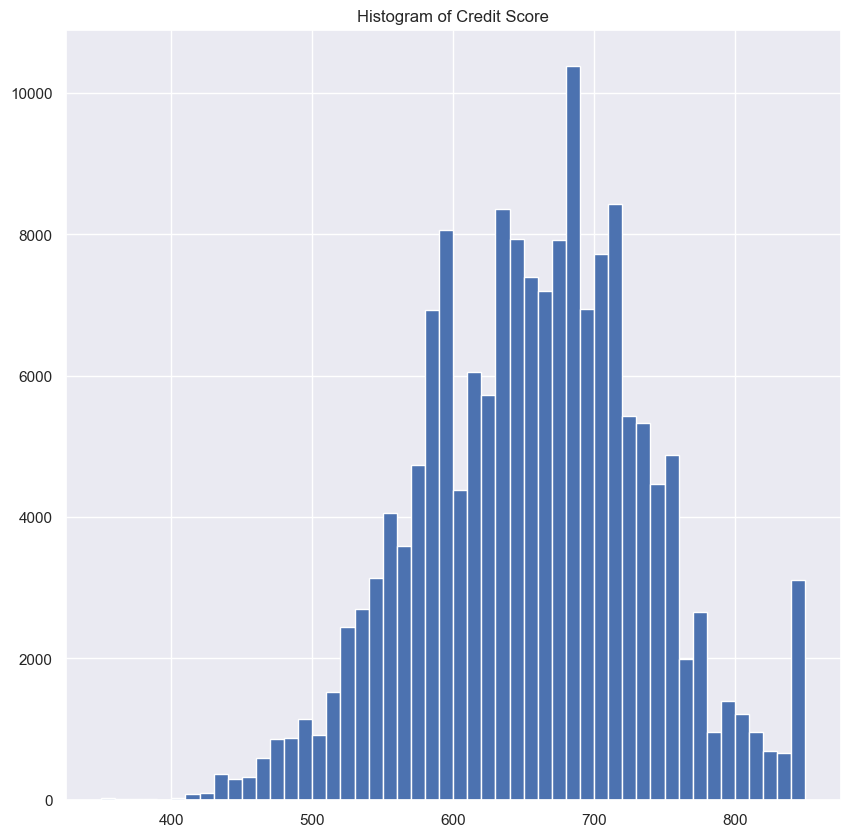

In [744]:
plt.hist(df['CreditScore'], bins=50)
plt.title("Histogram of Credit Score")
plt.show()

#### 🌎 Geography

Most of the users are from **France** with two mild imbalances for **Spain** and **Germany**.

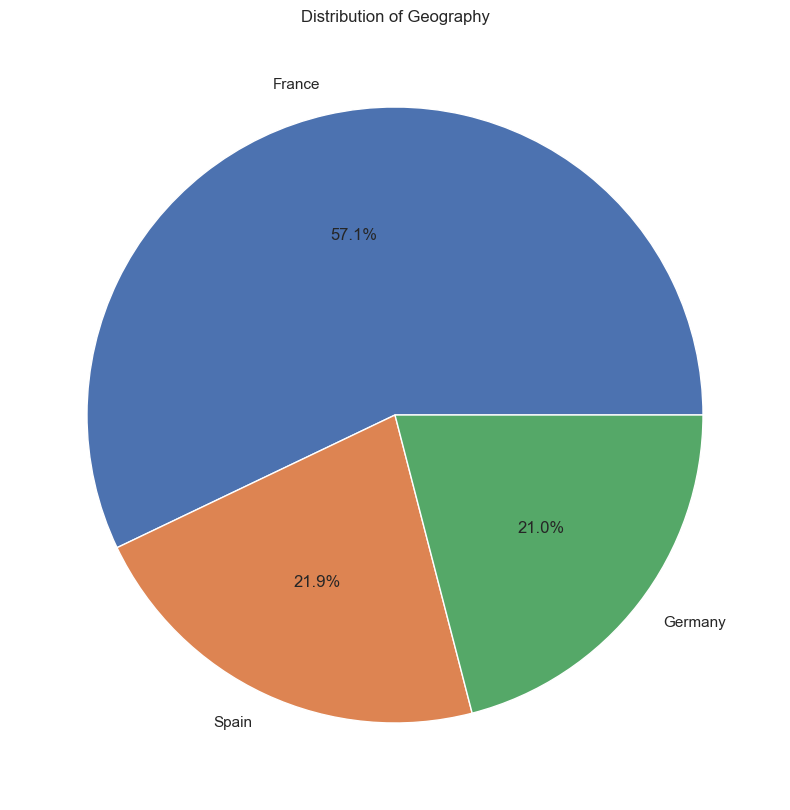

In [745]:
do_pie(df, 'Geography')

Looking at the distribution of those who did and did not churn, it is apparent that many more Germans will exit their accounts as opposed to not. Spanish exibit a close balance, and the French tend to not move their accounts around as much.

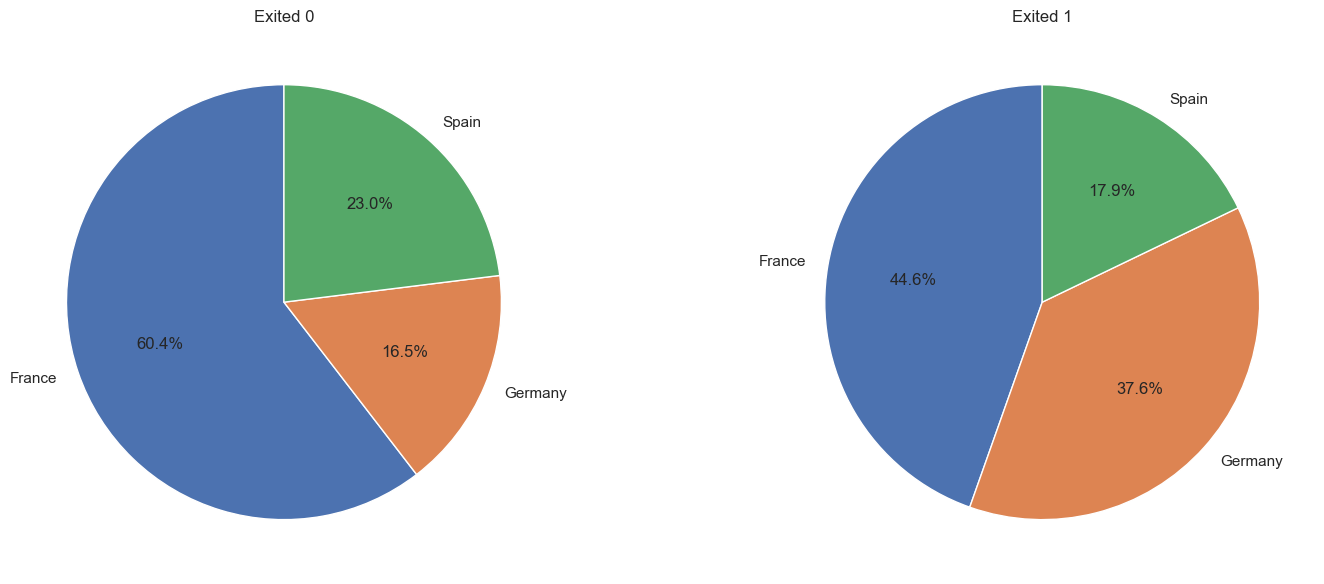

In [746]:
plot_target_representation(df, target, 'Geography')

In [747]:
df.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

#### ⚧ Gender

There are slightly more men than there are women, but it is not a particularly noteworthy imbalance.

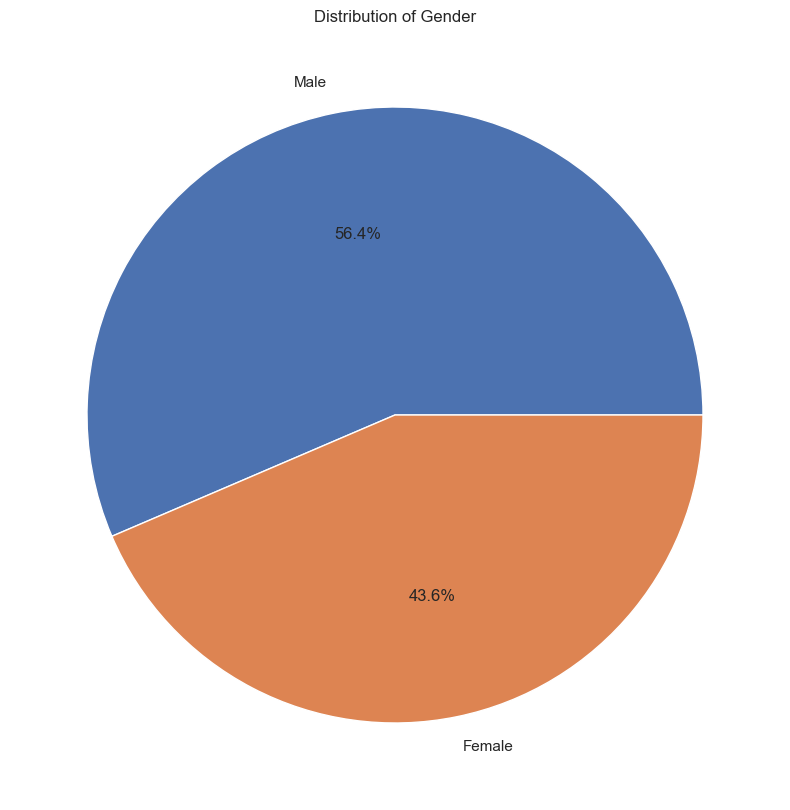

In [748]:
do_pie(df, 'Gender')

Women tend to be more likely to exit, men less likely than the general population

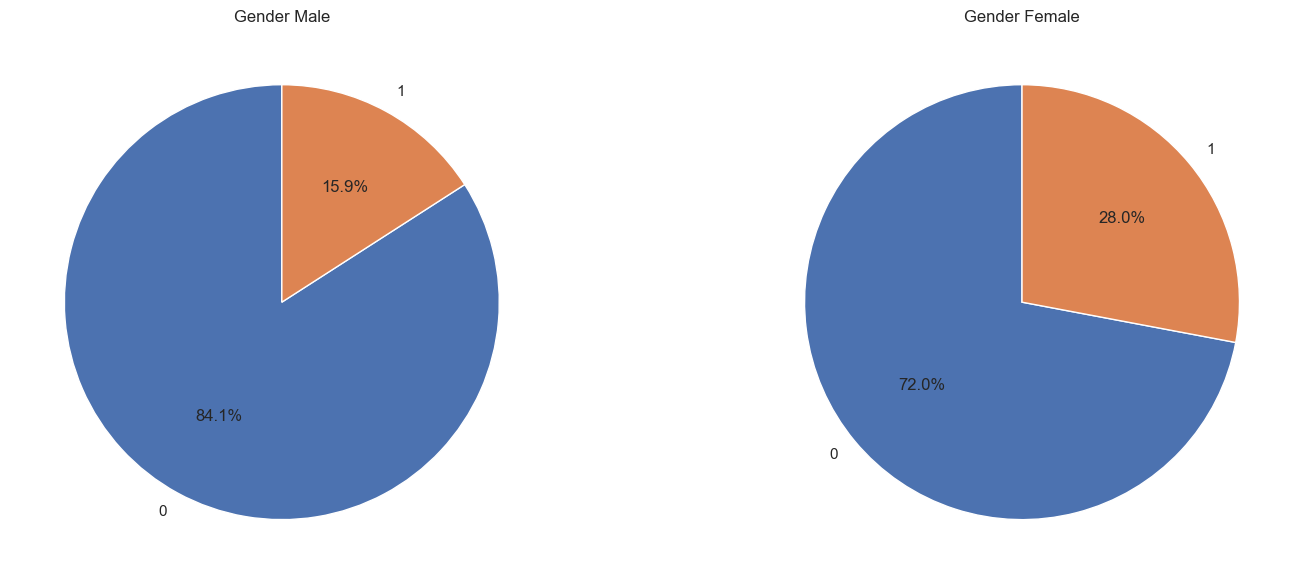

In [749]:
plot_target_representation(df, 'Gender')

In [750]:
df.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

#### Age

The plot looks a little wonky because age isn't given integer values, but it's actually quite a nice little normal distribution with the typical slight right skew (given that infants can't have bank accounts, and that some people live for very long times)

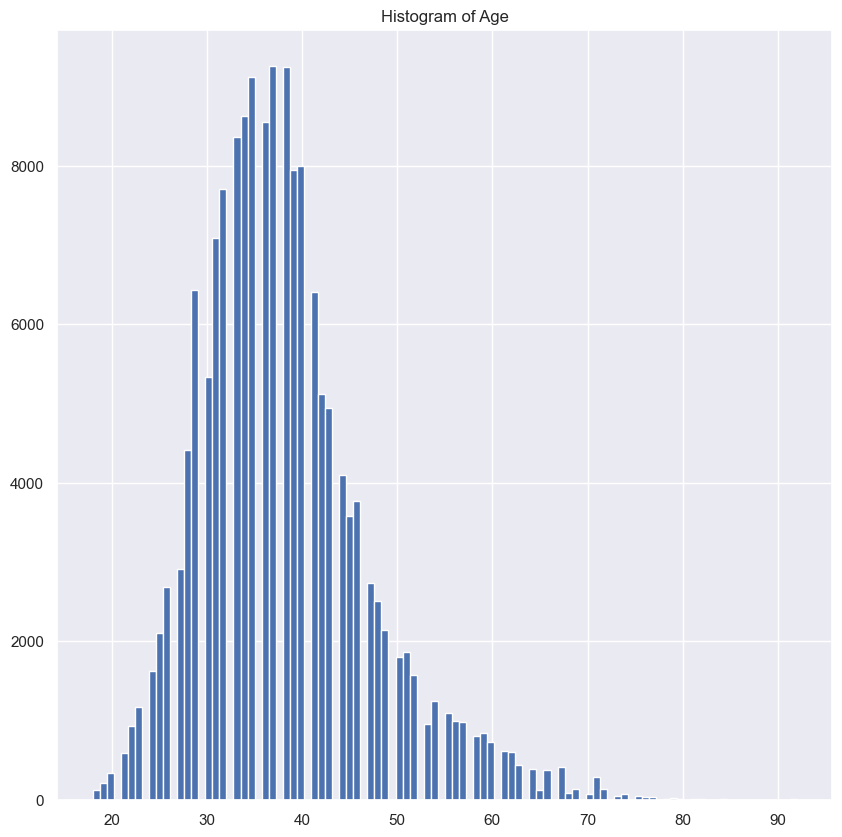

In [751]:
plt.hist(df['Age'], bins=100)
plt.title("Histogram of Age")
plt.show()

The boxplot for age seems very typical of EDA for machine learning. It might need some log transformation or outlier grouping.

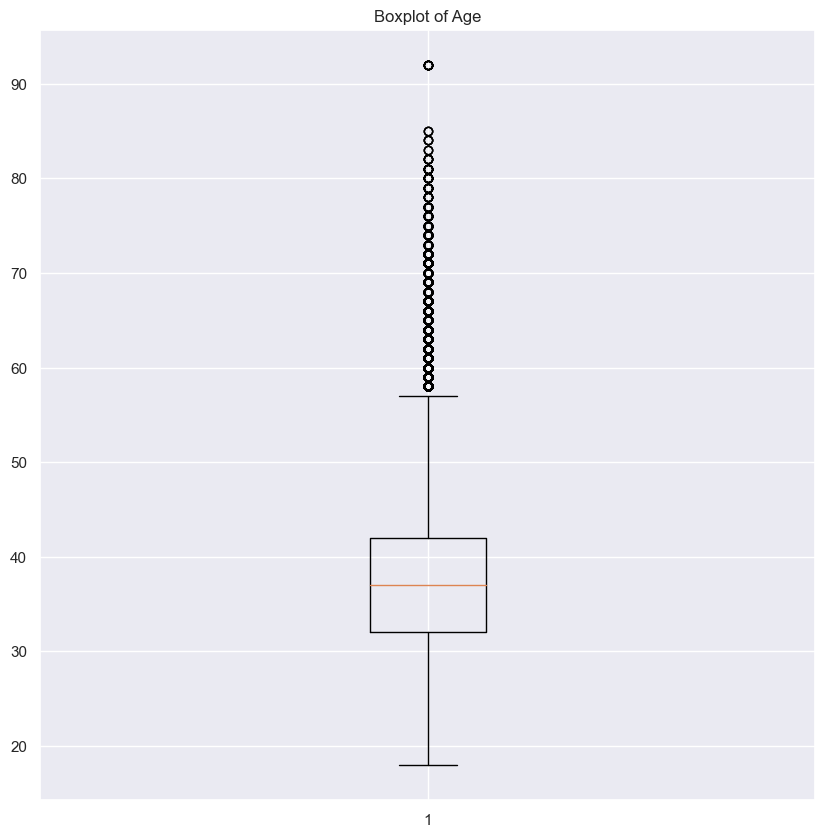

In [752]:
plt.boxplot(df['Age'])
plt.title("Boxplot of Age")
plt.show()

#### Tenure

For a variable with 10 different categories, **Tenure** is actually quite well-balanced. Fewer individuals have a **Tenure** value of ```0``` or ```10```

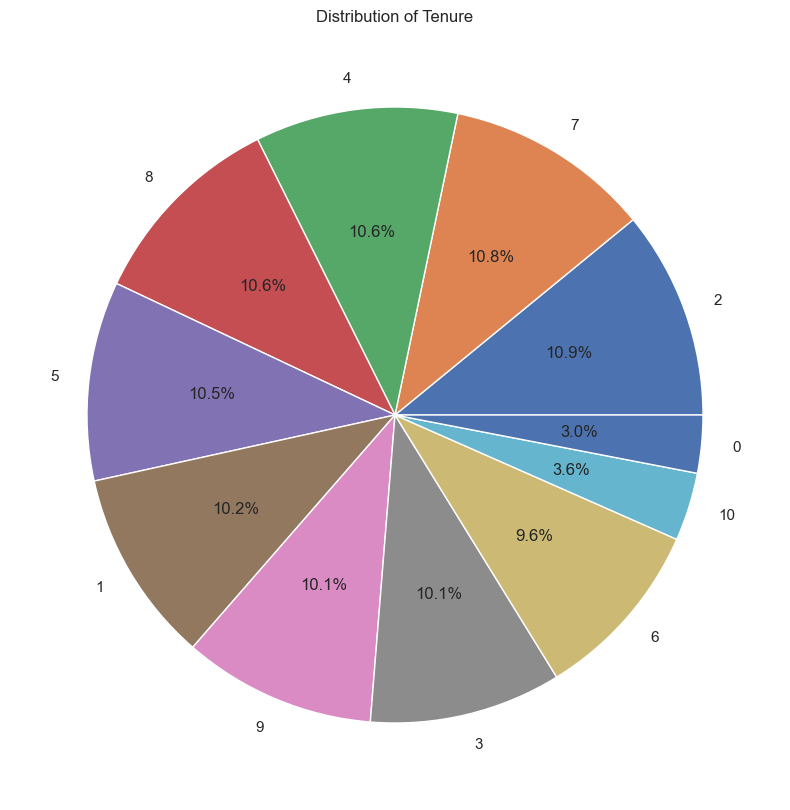

In [753]:
do_pie(df, 'Tenure')

The only particularly interesting patterns for the target representation's correlation with tenure are values of ```7```, which exhibits some negative correlation, and ```0``` which exhibits notably high correlation.

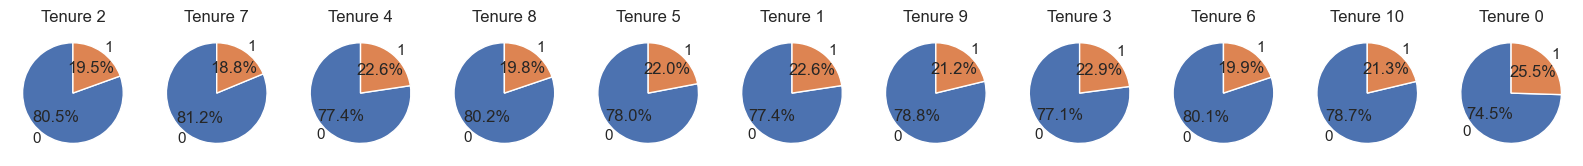

In [754]:
plot_target_representation(df, 'Tenure')

#### Balance

Looks like the majority of account-holders have next-to-nothing. This variable will likely need to be binned.

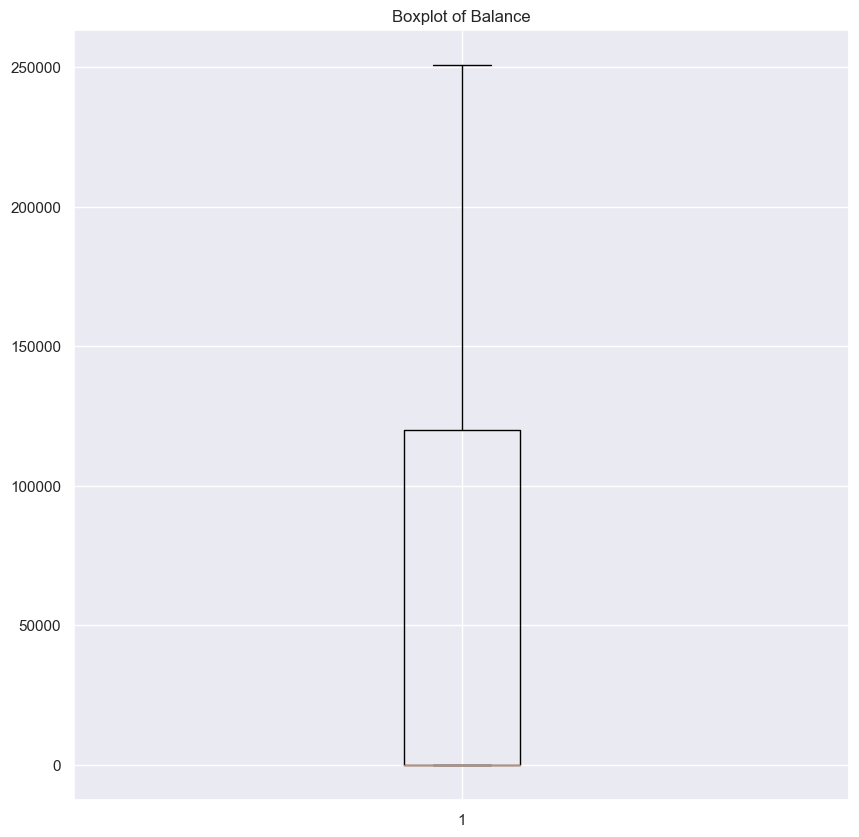

In [755]:
plt.boxplot(df['Balance'])
plt.title("Boxplot of Balance")
plt.show()

We can see that the vast majority of users have almost ```nothing``` in their account. The rest exhibit a relatively normal distribution between ```50000``` and ```20000``` worth of account holdings.

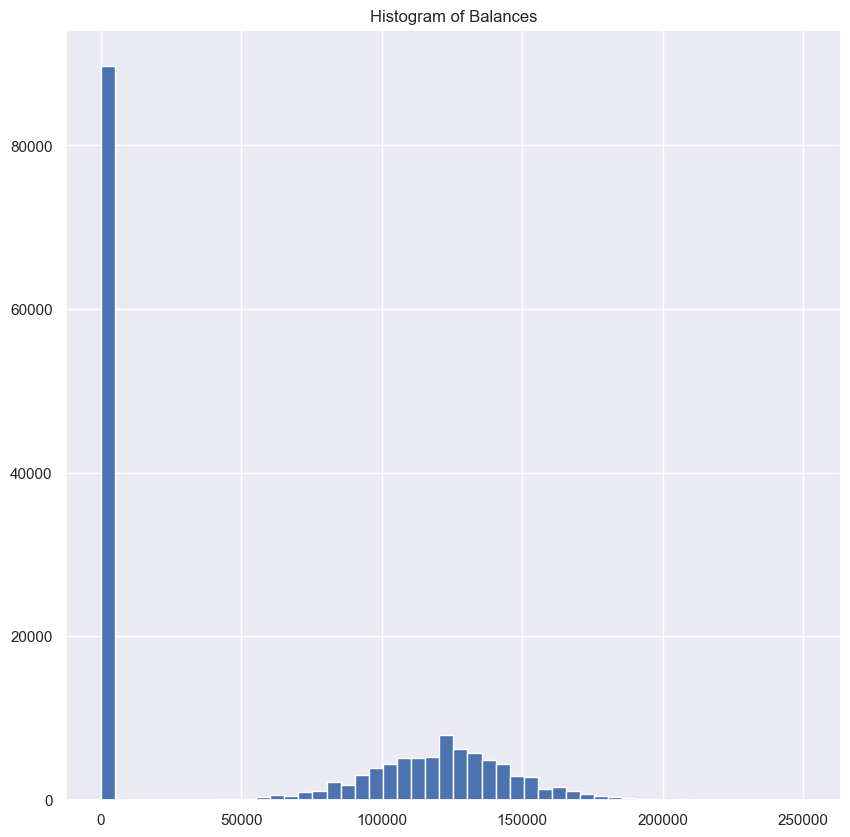

In [756]:
plt.hist(df['Balance'], bins=50)
plt.title("Histogram of Balances")
plt.show()

#### NumOfProducts

There is an **extreme** imbalance in ```3``` products, and a **severe** imbalance in ```4``` products. This variable should be examined to see if these can be aggregated as part of 2 products or something.

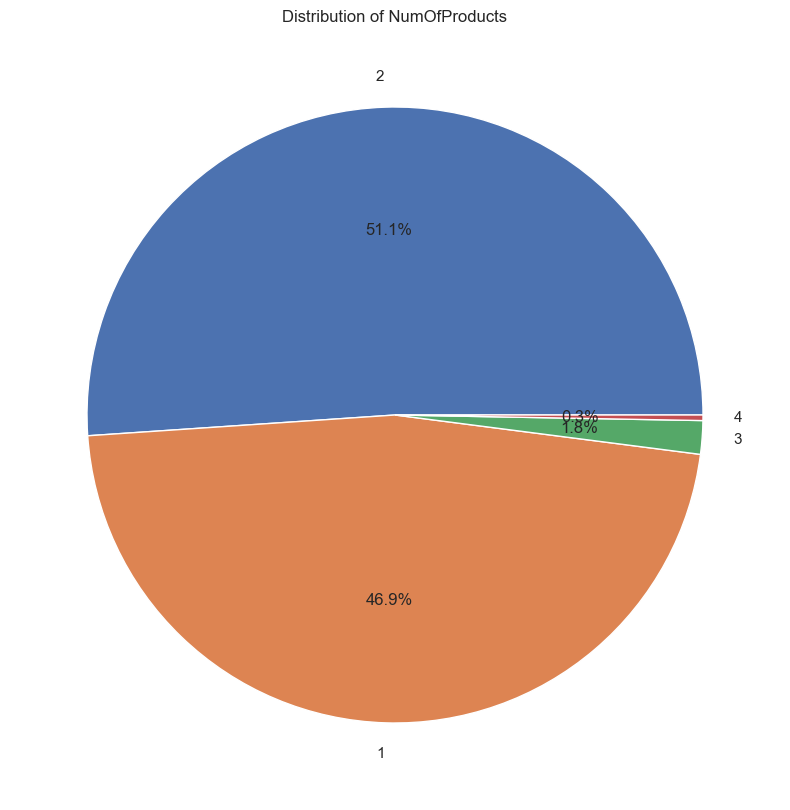

In [757]:
do_pie(df, 'NumOfProducts')

While the number of products values with ```3``` are a moderate-to-extreme minority, they still represent 2894 data points which is substantial enough to be worth considering. There are only **474** data points with ```4``` products, so these are statistically fairly insignificant.

In [758]:
df['NumOfProducts'].value_counts()

NumOfProducts
2    84291
1    77374
3     2894
4      475
Name: count, dtype: int64

We see some notable trends for the number of products.
* Those with ```1``` product have notably statistically higher percentages of exiting
* Those with ```2``` products have notably statistically lower percentages of exiting (with 6% compared to the 20.5% of the general population). 
* Those with ```3``` (and with ```4```) products have extremely high statistical percentages correlating to exiting.

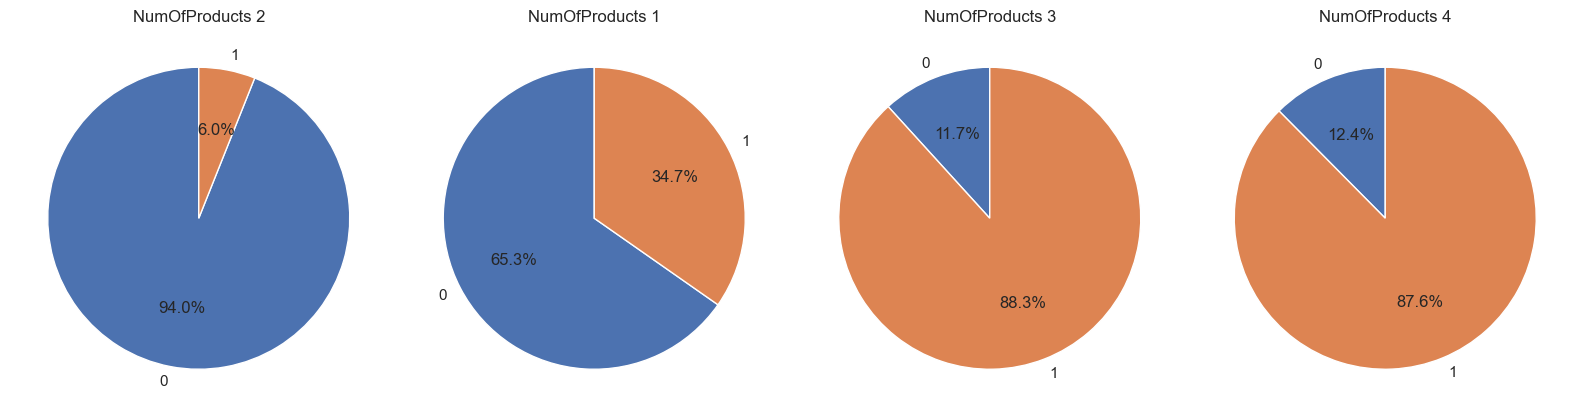

In [759]:
plot_target_representation(df, 'NumOfProducts')

#### Has CR Card

Most users have a credit card, only 25% do not.

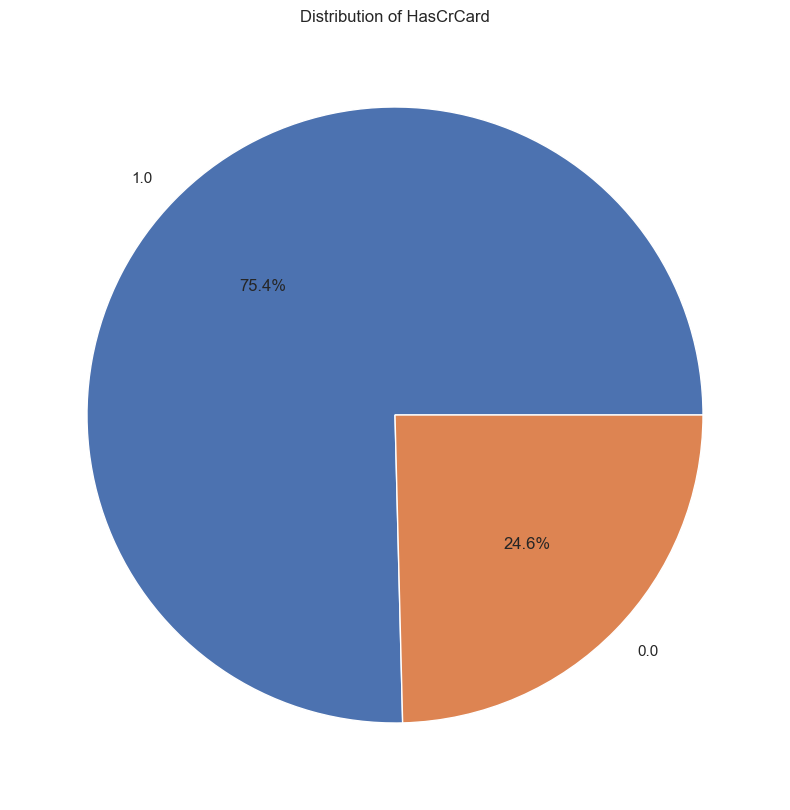

In [760]:
do_pie(df, 'HasCrCard')

There doesn't seem to be a particularly strong representation between exiting and those who do and do not have a credit card.
Those who do have a credit card seem to have a very slightly lower percentage for exiting and those who do not have a credit card have a very slightly lower percentage for exiting.

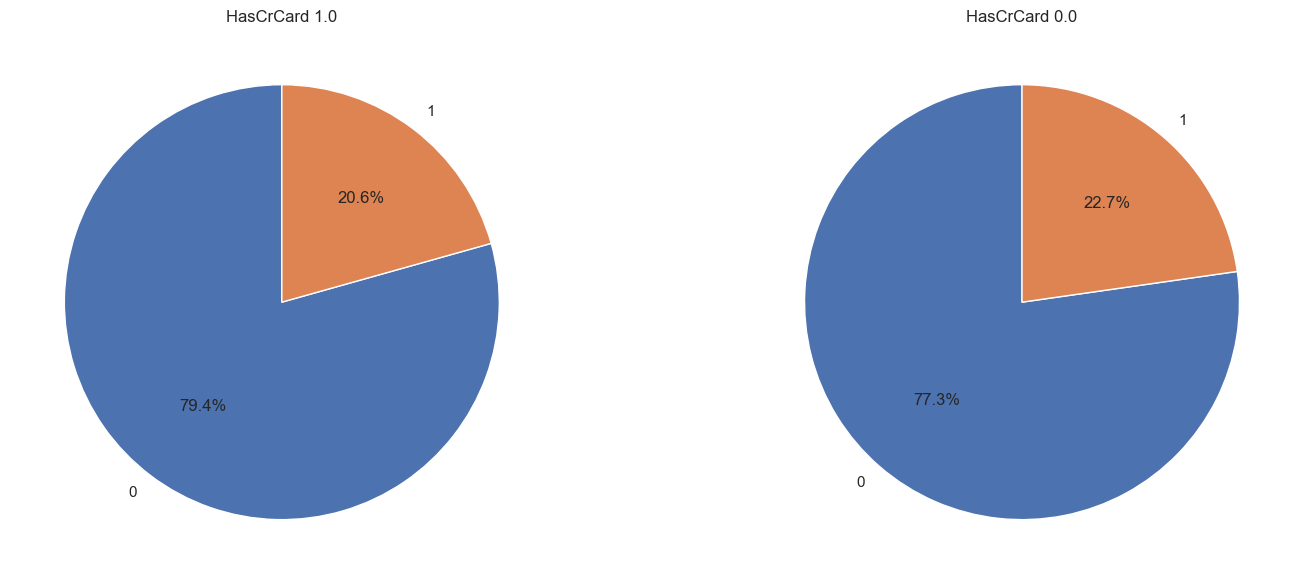

In [761]:
plot_target_representation(df, 'HasCrCard')

#### Is Active Member

There is a really nice split of those who are active members and those who are not.

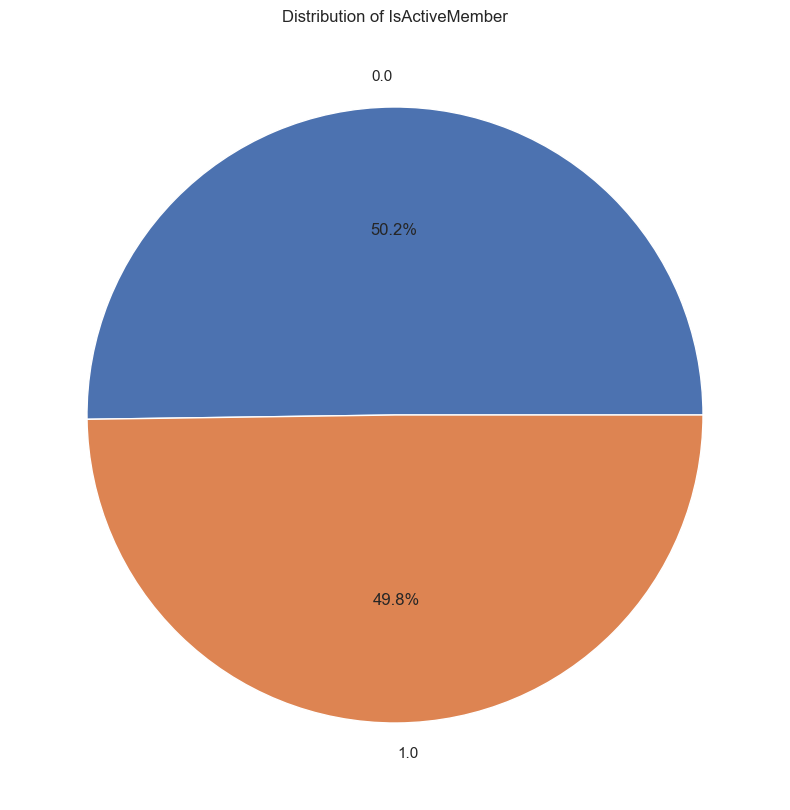

In [762]:
do_pie(df, 'IsActiveMember')

The level of activity exhibited by members seems to have a very notable correlation with the churn rate.

* ```Active Members``` exhibit a 12.5% churn rate compared to the general population's 20.5%
* ```Non-Active Members``` exhibit a 29.7% churn rate, nearly 10% higher than the general population.

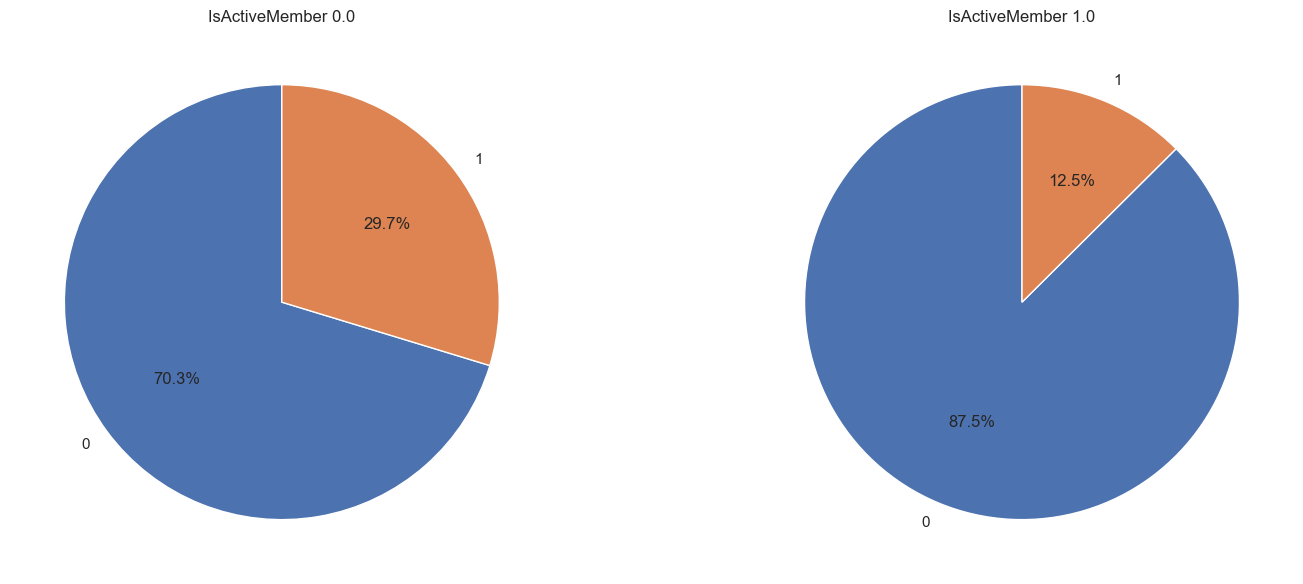

In [763]:
plot_target_representation(df, 'IsActiveMember')

#### Estimated Salary

Most people make around ```120k``` with a slight right skew on the curve.

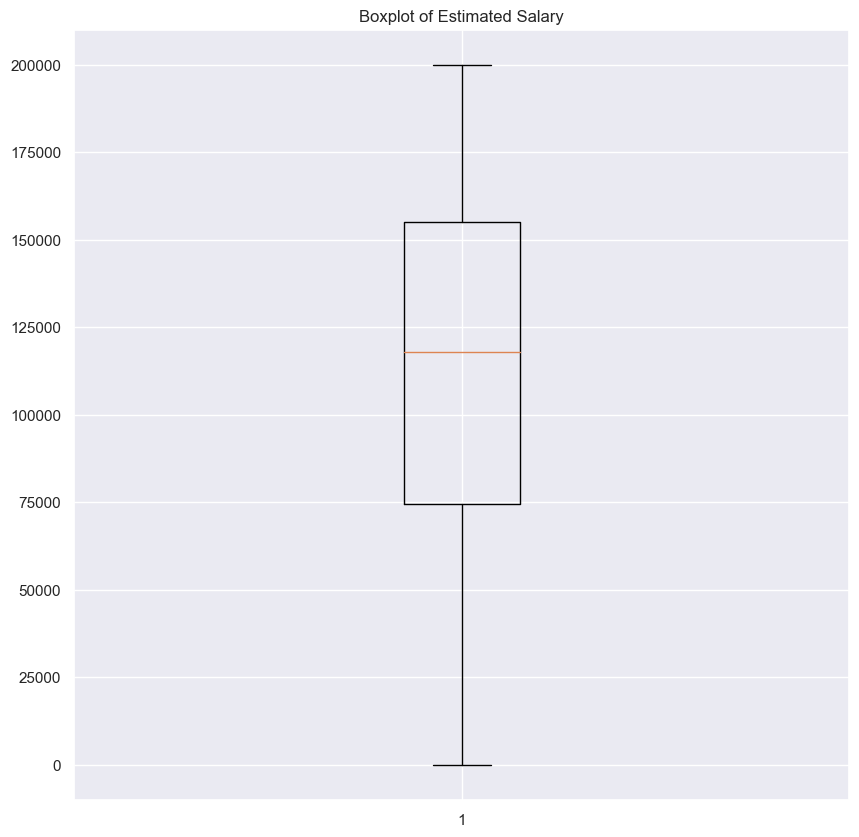

In [764]:
plt.boxplot(df['EstimatedSalary'])
plt.title("Boxplot of Estimated Salary")
plt.show()

The curve for estimated salary is a bit ugly, with a few notable clusters around thresholds (50-60, 75-90, 120-140, ...). 2500 data points make nothing.

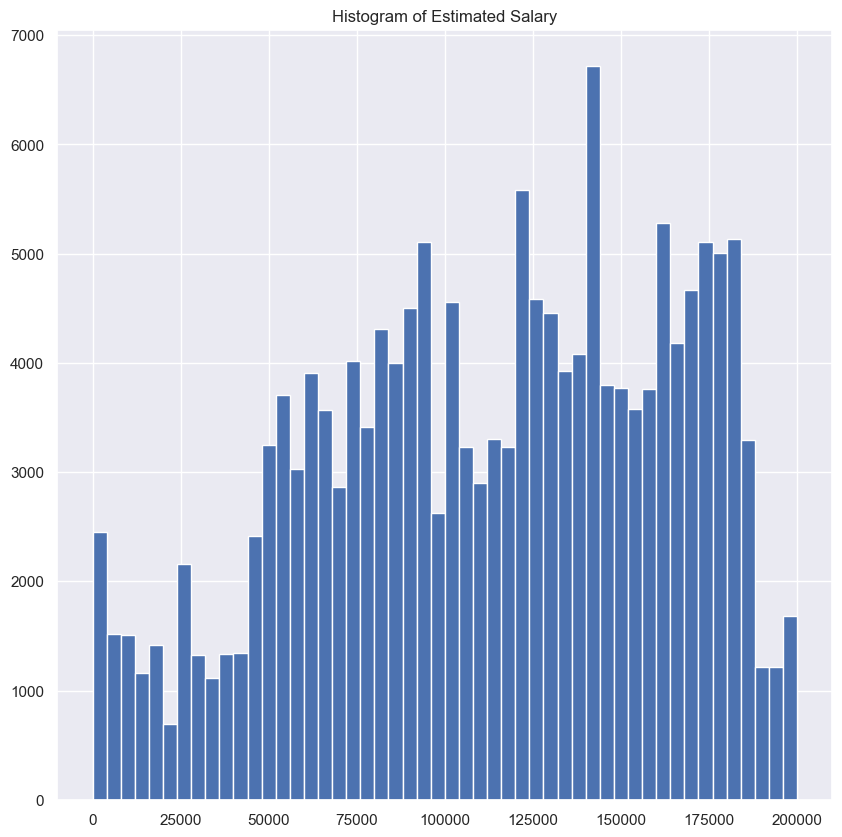

In [765]:
plt.hist(df['EstimatedSalary'], bins=50)
plt.title("Histogram of Estimated Salary")
plt.show()

## Data Cleaning

Below, we define the categorical variables for encoding. Binary categorical variables will likely stay untouched.
We declare the numerical variables for scaling.
We declare the variables we are not interested in keeping for model training.

In [766]:
categorical_variables = ['IsActiveMember', 'HasCrCard', 'Gender', 'NumOfProducts', 'Tenure', 'Geography']
numerical_variables = ['EstimatedSalary', 'Age', 'Balance', 'CreditScore', ]
remove = ['id', 'CustomerId', 'Surname']

categorical_variables.remove('Tenure')
numerical_variables.append('Tenure')

categorical_variables.remove('NumOfProducts')
numerical_variables.append('NumOfProducts')

### Final Analysis

While this is more of an EDA measure (not data cleaning), the below cell still gives us some interesting information.
* It actually looks like a few of the bins for estimated salary see slightly higher exit rates in proportion to some of the smaller salaries.
* A lot more of the older folks tend to exit relative to younger.
* Those with ```some``` balance tended to see higher exit rates than those with ```no``` balance.
* it is difficult to make anything out of credit score.

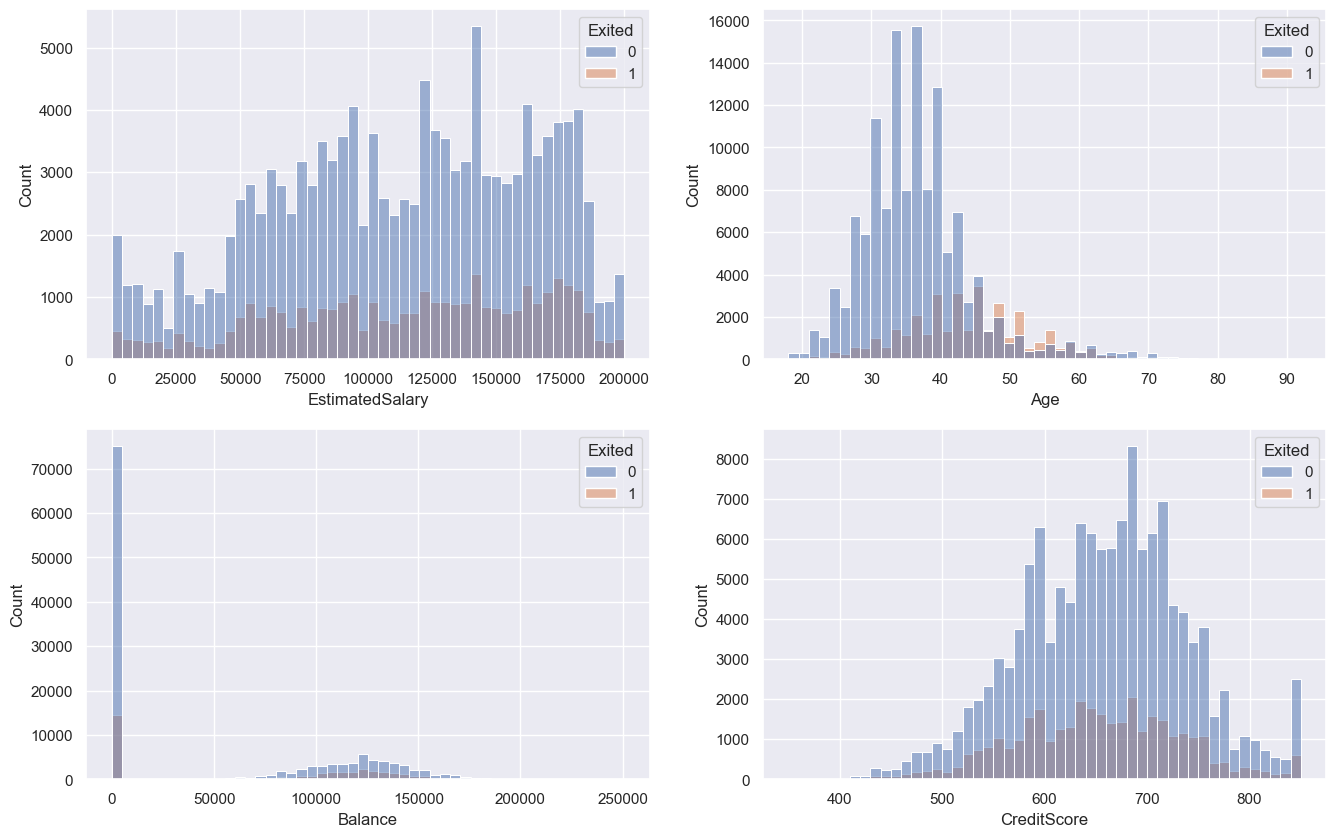

In [767]:
_, axes = plt.subplots(nrows= 2, ncols=2, figsize=(16,10))
for feat, ax in zip(numerical_variables, axes.ravel()):
    if df[feat].dtype == 'object':
        sns.countplot(data=df, x=feat, ax=ax, hue=target)
    else:
        sns.histplot(data=df, x=feat, bins=50, ax=ax, hue=target)
plt.show()

Likewise, while this is also more of eda, running the countplots of the categorical variables proves useful.
* Active members have a lower exit rate than non-active members
* Women tend to have higher exit rates than men
* Those with ```1```, ```3```, or ```4``` products tend to have notably higher exit rates than those with ```2``` products
* ```Germany``` has notably higher exit rates. ```France``` has notably lower exit rates.

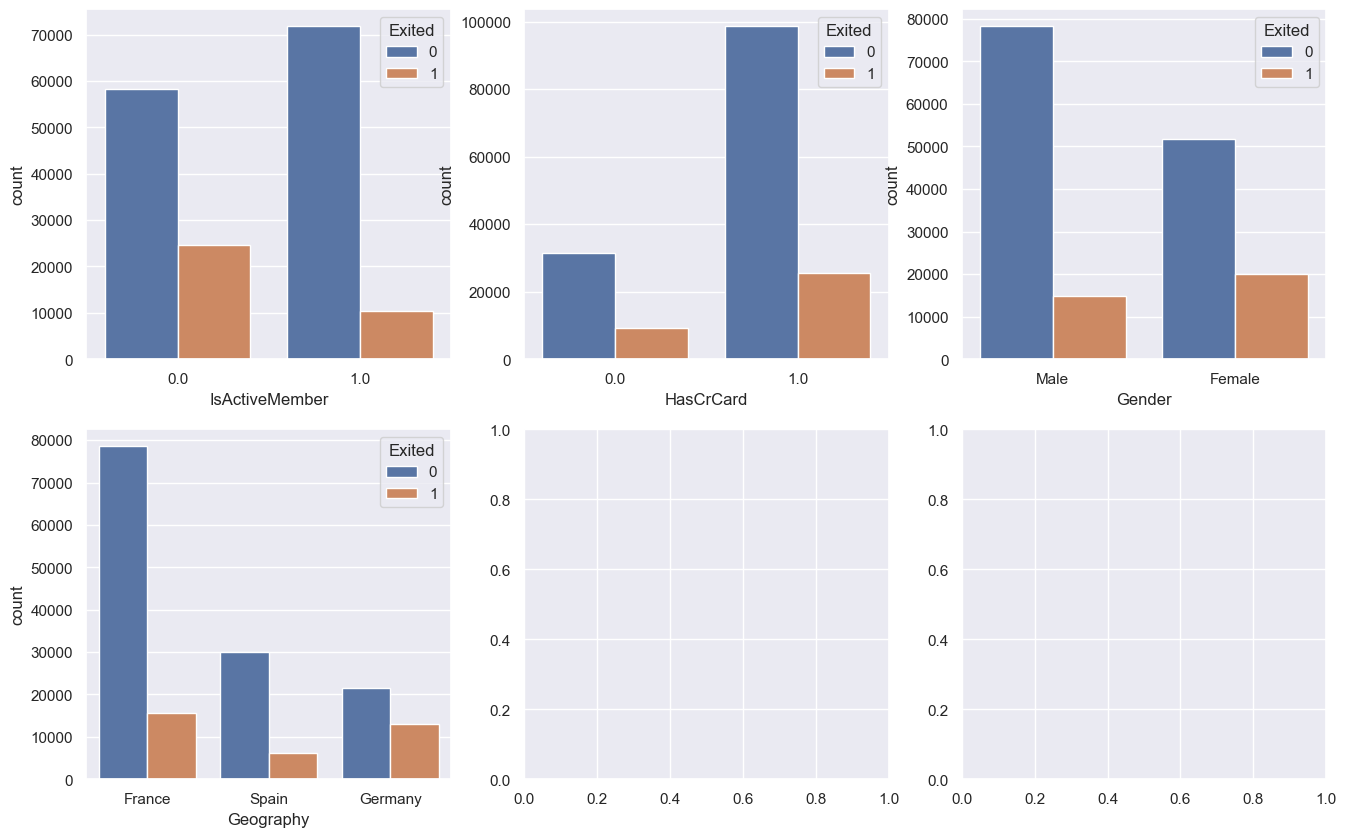

In [768]:
_, axes = plt.subplots(nrows= 2, ncols=3, figsize=(16,10))
for feat, ax in zip(categorical_variables, axes.ravel()):
    sns.countplot(data=df, x=feat, ax=ax, hue=target)
plt.show()

In [769]:
df_clean = df.copy()

### Feaure Engineering

In [770]:
df_clean['isSenior'] = df['Age'].apply(lambda x: 1 if x >=60 else 0)

In [771]:
df_clean['activeByCard'] = df_clean['HasCrCard'] * df_clean['IsActiveMember']

In [772]:
df_clean['productsPerTenure'] = df_clean['Tenure'] / df_clean['NumOfProducts']

In [773]:
df_clean['ageCat'] = np.round(df_clean.Age/20).astype('int').astype('category')

In [774]:
# df_clean['isSenior'] = df['Age'].apply(lambda x: 1 if x >=60 else 0)
# df_clean['activeByCard'] = df_clean['HasCrCard'] * df_clean['IsActiveMember']
# df_clean['productsPerTenure'] = df_clean['Tenure'] / df_clean['NumOfProducts']
# df_clean['ageCat'] = np.round(df_clean.Age/20).astype('int').astype('category')

### Actual Cleaning

In [775]:
df_clean = df_clean.drop(remove, axis=1)
df_clean.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'isSenior', 'activeByCard', 'productsPerTenure', 'ageCat'],
      dtype='object')

In [776]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

df_clean[numerical_variables] = scaler.fit_transform(df_clean[numerical_variables])
df_clean.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,isSenior,activeByCard,productsPerTenure
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,0.612909,0.271971,0.502035,0.221118,0.184818,0.753954,0.497770,0.562870,0.211599,0.028733,0.370766,3.662846
std,0.160207,0.119827,0.280616,0.250371,0.182385,0.430707,0.499997,0.251488,0.408443,0.167057,0.483011,2.517497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.494000,0.189189,0.300000,0.000000,0.000000,1.000000,0.000000,0.373166,0.000000,0.000000,0.000000,1.666667
50%,0.618000,0.256757,0.500000,0.000000,0.333333,1.000000,0.000000,0.589738,0.000000,0.000000,0.000000,3.000000
75%,0.720000,0.324324,0.700000,0.478041,0.333333,1.000000,1.000000,0.775779,0.000000,0.000000,1.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


In [777]:
# Helper function to encode a variable
def encode(df, cols):
    new_categories = []
    for col in cols:
        if col in df.columns:
            one_hot_encoded = pd.get_dummies(df[col], prefix=col)
            for new_col in one_hot_encoded.columns:
                new_categories.append(new_col)
            df = pd.concat([df, one_hot_encoded], axis=1)
            if not (col == target):
                df = df.drop([col], axis = 1)
    return df, new_categories

In [778]:
df_clean, _ = encode(df_clean, categorical_variables)
df_clean.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'Exited', 'isSenior', 'activeByCard',
       'productsPerTenure', 'ageCat', 'IsActiveMember_0.0',
       'IsActiveMember_1.0', 'HasCrCard_0.0', 'HasCrCard_1.0', 'Gender_Female',
       'Gender_Male', 'Geography_France', 'Geography_Germany',
       'Geography_Spain'],
      dtype='object')

The **balance** has a strong correlation with many variables. This includes a strong negative correlation with number of products, a slight positive correlation with exiting, a slight negative correlation with geography from france, a very high positive correlation with germany, and a very slight negative correlation with being from spain.
    - It is likely that combining some feature variable that looks at number of products combined with geography could be useful. 

* **Age**, which is one of the most valuable features, has very little correlation with any of the other features aside from the target variable.
* **Tenure** applies similarly with the observations seen in age.
* **Estimated Salary** has the same observations.

* **Has Credit Card** doesn't correlate very highly with other variables as well, but it is low on the significance score for baseline machine learning models.

* **Credit Score** doesn't seemingly have a very high correlation with any other variables even though we know it is one of the most important variables in predicting bank churn.

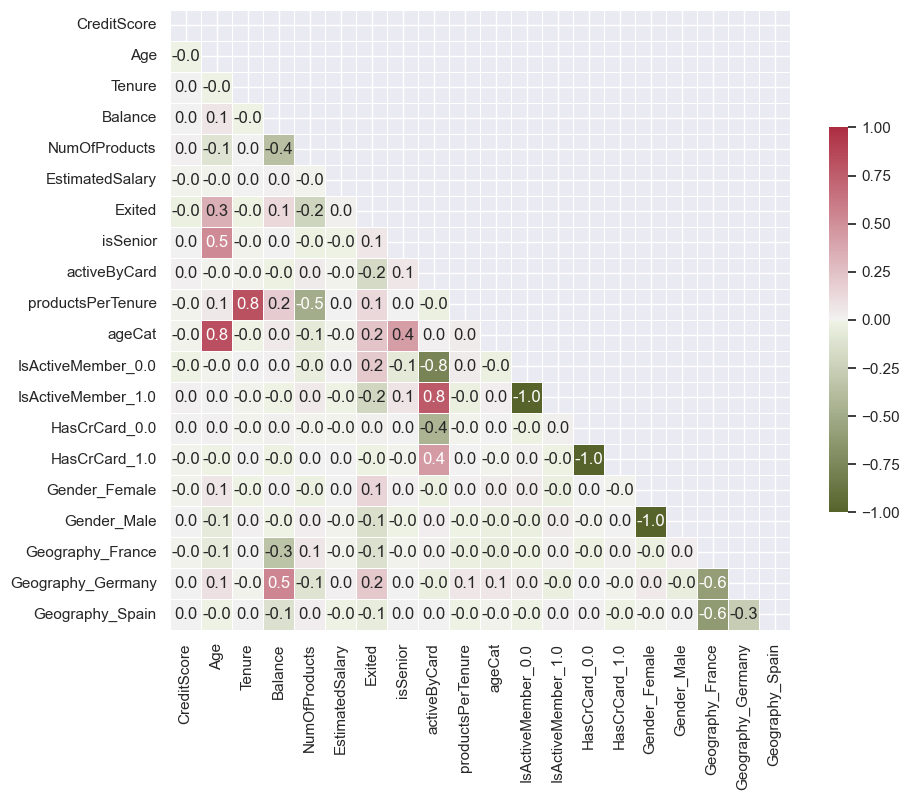

In [779]:
sns.set(rc={'figure.figsize':(10,10)})

corr = df_clean.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5}, annot=True, fmt='.1f')
plt.show()

In [780]:
features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary',
            

       'ageCat',
       
       # isSenior saw worse performance on single model validation and in 5 fold cross validation
       # 'isSenior',

       # 'IsActiveMember_0.0',
       'IsActiveMember_1.0', 
       # 'HasCrCard_0.0',
       'HasCrCard_1.0',
       'activeByCard',

       'Gender_Female',
       
       # 'Gender_Male',

       'NumOfProducts',
       # 'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',

       'productsPerTenure',

       'Tenure',
       # 'Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3', 'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7', 'Tenure_8', 'Tenure_9', 'Tenure_10',
       
       'Geography_France',
       'Geography_Germany', 'Geography_Spain']

counter = Counter(df_clean[target])
pos_estimate = counter[0] / counter[1]
print('Pos Estimate: %.3f' % pos_estimate)

X_train, X_test, y_train, y_test = train_test_split(df_clean[features], df_clean[target], test_size=0.2, random_state=42, stratify=df_clean[target])
# X_train = df_clean[features]
# y_train = df_clean[target]

Pos Estimate: 3.726


## 🤖 Machine Learning

### 🌳 Decision Tree Classifier

In [781]:
classifier = DecisionTreeClassifier(max_depth=50)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50)

In [782]:
# Predict using the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     26023
           1       0.52      0.54      0.53      6984

    accuracy                           0.80     33007
   macro avg       0.70      0.70      0.70     33007
weighted avg       0.80      0.80      0.80     33007



### XGBoost

#### Initialize and Fit the Model

In [783]:
xgb_params =  {'colsample_bytree': 0.8,
               'learning_rate': 0.1,
               'max_depth': 4,
               'scale_pos_weight': pos_estimate,
               'eval_metric': "auc",
               'n_estimators': 50,
               'early_stopping_rounds': 400,
               'enable_categorical': True,
            #    'tree_method': 'hist',
               'subsample': 0.9}

xgb_model = XGBClassifier(**xgb_params )
# xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train, verbose=50, eval_set=[(X_test, y_test)] )
# xgb_model.fit(X_train, y_train, verbose=50 )

[0]	validation_0-auc:0.86106
[49]	validation_0-auc:0.88841


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=400,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Hyperparameter Tuning

Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
Best score found:  0.8653078536965925

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.9}
Best score found:  0.888987004778651

.88900

In [784]:
param_grid = {
    # 'n_estimators': [50, 75, 100, 400, 600, 700, 800, 900, 1000],
    'n_estimators': [400],
    # 'learning_rate': [0.1, 0.2, 0.3],
    # 'learning_rate': [0.1],
    # 'max_depth': [2, 3, 4, 5, 6, 8, 10, 12],
    'max_depth': [4],
    # 'subsample': [0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.8, 0.9, 1.0],
}

perform_xgb_tuning = True

if perform_xgb_tuning == True:
    model = XGBClassifier(**xgb_params)
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2, scoring="roc_auc")
    grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)
else:
    print("Hyperparameter tuning skipped.")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[0]	validation_0-auc:0.86160
[0]	validation_0-auc:0.86160
[0]	validation_0-auc:0.86111
[1]	validation_0-auc:0.85955
[0]	validation_0-auc:0.86141
[1]	validation_0-auc:0.85998
[1]	validation_0-auc:0.86008
[2]	validation_0-auc:0.86963
[1]	validation_0-auc:0.85890
[2]	validation_0-auc:0.86797
[3]	validation_0-auc:0.86934
[2]	validation_0-auc:0.86766
[2]	validation_0-auc:0.86916
[3]	validation_0-auc:0.86859
[0]	validation_0-auc:0.86126
[4]	validation_0-auc:0.87221
[3]	validation_0-auc:0.86963
[4]	validation_0-auc:0.87263
[5]	validation_0-auc:0.87133
[3]	validation_0-auc:0.86809
[1]	validation_0-auc:0.85895
[5]	validation_0-auc:0.87177
[6]	validation_0-auc:0.87365
[4]	validation_0-auc:0.87269
[6]	validation_0-auc:0.87370
[2]	validation_0-auc:0.86770
[4]	validation_0-auc:0.87250
[7]	validation_0-auc:0.87842
[5]	validation_0-auc:0.87163
[7]	validation_0-auc:0.87853
[6]	validation_0-auc:0.87404
[8]	validation_0-auc:0.88034
[5]	validation_0-auc:0.87223
[3]	validation_0-auc:0.86884
[8]	validation

#### Making Predictions

In [785]:
y_pred_xgboost = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     26023
           1       0.52      0.54      0.53      6984

    accuracy                           0.80     33007
   macro avg       0.70      0.70      0.70     33007
weighted avg       0.80      0.80      0.80     33007



#### ROC Curve

baseline: 0.8886

isSenior: 0.8884

isSenior and activeByCard: 0.8848

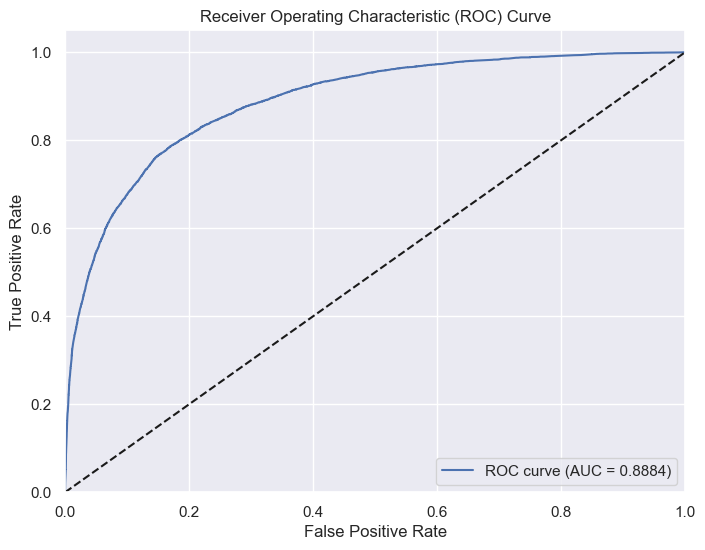

In [786]:
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
# Calculate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [787]:
y_pred_prob

array([0.28996015, 0.885929  , 0.07586987, ..., 0.15682401, 0.03543866,
       0.15256575], dtype=float32)

#### XGBoost Feature Importances

The initial model emphasizes **Age** as the most important feature. The age of an individual must be a crucial role. This is followed by similarly-important **Credit Scire**, **Balance**, and **Estimated Salary**. 

The model heavily weighs these variables as top predictors.

<Figure size 1000x800 with 0 Axes>

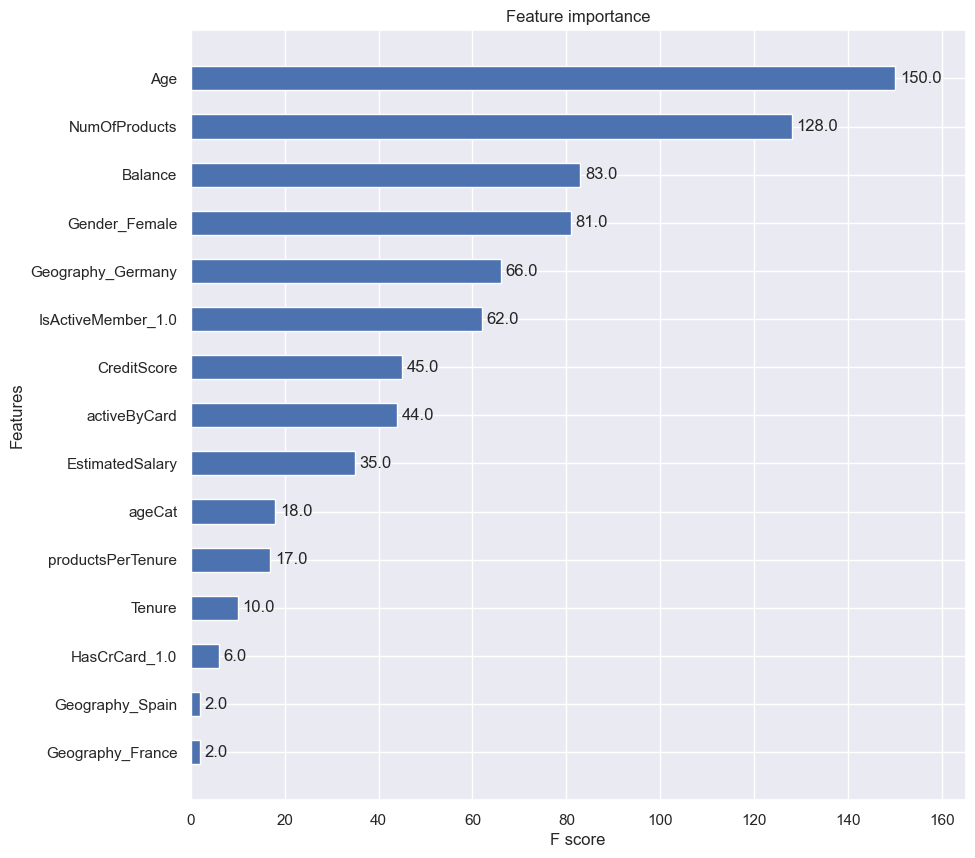

In [788]:
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, height=0.5)
plt.show()

## 👀 Observations

Having **Tenure** as a numerical variable sees notable improvements in performance - accuracy moves from 79 to 80

## ✅ Submission

In [789]:
df_final = pd.read_csv('./test.csv')
df_final.shape

(110023, 13)

In [790]:
df_final_clean = df_final.copy()

In [791]:
df_final_clean['isSenior'] = df_final_clean['Age'].apply(lambda x: 1 if x >=60 else 0)
df_final_clean['activeByCard'] = df_final_clean['HasCrCard'] * df_final_clean['IsActiveMember']
df_final_clean['productsPerTenure'] = df_final_clean['Tenure'] / df_final_clean['NumOfProducts']
df_final_clean['ageCat'] = np.round(df_final_clean.Age/20).astype('int').astype('category')

In [792]:
df_final_clean = df_final_clean.drop(remove, axis=1)

In [793]:
df_final_clean[numerical_variables] = scaler.fit_transform(df_final_clean[numerical_variables])

In [794]:
df_final_clean, _ = encode(df_final_clean, categorical_variables)

In [795]:
# preds = classifier.predict(df_final_clean[features])
preds = xgb_model.predict_proba(df_final_clean[features])
# y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

preds[:10]

array([[0.917187  , 0.08281304],
       [0.08748275, 0.91251725],
       [0.87776923, 0.12223075],
       [0.44827318, 0.5517268 ],
       [0.33335686, 0.66664314],
       [0.8480131 , 0.1519869 ],
       [0.8449    , 0.15510002],
       [0.75434095, 0.24565905],
       [0.1466605 , 0.8533395 ],
       [0.94808376, 0.05191622]], dtype=float32)

In [796]:
df_idc = pd.read_csv('./sample_submission.csv')
df_idc.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [797]:
submission_df = pd.DataFrame()
submission_df['id'] = df_final['id']
submission_df['Exited'] = preds[:, 1]
submission_df.head()

,id,Exited
0,165034,0.082813
1,165035,0.912517
2,165036,0.122231
3,165037,0.551727
4,165038,0.666643


In [798]:
submission_df.to_csv('./submission.csv', index=False)